<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>      

# Problema: Clasificación binaria de mensajes sexistas con algoritmos clásicos de aprendizaje supervisado.

El objetivo de este problema es entrenar y evaluar un modelo para la clasificación de mensajes sexistas, utilizando algoritmos clásicos de aprendizaje automático, tales como Support Vector Machine.

El dataset a utilizar es la colección de textos proporcionada por los organizadores de la tareas EXIST 2021. Este dataset puede solicitarse para usos en investigación en el siguiente [link](#http://nlp.uned.es/exist2021/).



Dicho dataset está compuesto por una colección de tweets y comentarios de Gab (conocida por ser una red social de usuarios de extrema derecha). Hay textos tanto en inglés como en español, y han sido anotados para indicar si contienen un mensaje sexista o no. Un texto se considera sexista, si tiene un mensaje sexista, pero también aquellos que están describiendo una situación sexista o están criticando un comportamiento sexista.

- **SEXIST**: Por ejemplo, “Mujer al volante, tenga cuidado!", "El comportamiento de Rubiales ha sido intolerable" (no es un mensaje sexista, pero sí informa sobre un comportamiento sexista).
- **NOT SEXIST**: “Alguien me explica que zorra hace la gente en el cajero que se demora tanto."

El dataset contiene 6.977 tweets para entrenaiento y 3.386 para evaluación. En ambos conjunto, las clases sexist y not sexist están balanceadas.



**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/exist2021/'.



## Cargar el dataset

Lo primero que debes hacer es cargar el dataset. Como hemos comentado antes, recuerda que para que puedas ejecutar este notebook, deberás haber descargado los ficheros del dataset y haberlos almacenados en tu carpeta 'Colab Notebooks/data/exist2021/' dentro de tu Gooogle Drive.



In [1]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/exist2021/')

Mounted at /content/drive


Cargamos los conjuntos de datos de training y evaluación en dos objetos dataframes de pandas:

In [2]:
import pandas as pd

df_train = pd.read_csv("train.tsv",  sep='\t')
df_test = pd.read_csv("test.tsv",  sep='\t')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_train.head()

tamaño training: (6977, 7)
tamaño test: (4368, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


El dataset es multilingüe, vamos a quedarnos únicamente con los textos en inglés:

In [3]:
df_train=df_train[df_train['language']=='en']
df_test=df_test[df_test['language']=='en']
print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)


tamaño training: (3436, 7)
tamaño test: (2208, 7)


La competición EXIST 2021 proponía dos tareas: la clasificación binaria de los comenarios (sexistas y no sexistas) y una multiclasificación de los mensajes sexistas en distintos tipos. En este problema nos centramos en la tarea binaria. Las etiquetas de esta tarea están almacenadas en el campo **task1**. En realidad, únicamente vamos a uilizar los campos **task1** y **task1**. Podemos eliminar el resto de los campos:

In [4]:
df_train = df_train.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_test = df_test.drop(['test_case', 'id', 'source', 'task2'], axis=1)
# renombramos task1 a label
df_train = df_train.rename(columns={'task1':'label'})
df_test = df_test.rename(columns={'task1':'label'})
# mostramos los primeros registros del training
df_train.head()

,language,text,label
0,en,"She calls herself ""anti-feminazi"" how about sh...",sexist
1,en,"Now, back to these women, the brave and the be...",non-sexist
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist
3,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist
4,en,i find it extremely hard to believe that kelly...,non-sexist


### Preprocesamiento

Los textos deben ser transformados a un formato entendible por un algoritmo de aprendizaje automático.

También vamos a aplicaremos algunas tareas básicas de PLN para limpiar y normalizar el texto:

- tokenización
- transformar a minúsculas
- eliminar stopwords
- aplicar stemming sobre cada token, para obtener su raíz.
- eliminar cualquier palabra que contenga algún dígito o signo de puntuación.




In [5]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re


def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 3 caráceres
    min_length = 3
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial
    p = re.compile('^[a-zA-Z]+$');

    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)

    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Label encoding

Esta tarea consiste en transformar las labels de formato a texto a un formato numérico.


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()


# print(LABELS)


# print(idx2label)
print('Labels:', label2idx)
print()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
LABELS = le.classes_
NUM_LABELS = len(LABELS)
print("después de transform:", y_train[:10])

print("antes de transform: ", y_test[:10])
y_test = le.transform(y_test)
print("después de transform:", y_test[:10])

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])
#y_train_cat = to_categorical(y_train)
#y_test_cat = to_categorical(y_test)

Labels: {'non-sexist': 0, 'sexist': 1}

antes de transform:  ['sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'non-sexist']
después de transform: [1 0 1 0 0 1 0 0 0 0]
antes de transform:  ['non-sexist', 'non-sexist', 'sexist', 'sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'sexist', 'sexist', 'non-sexist']
después de transform: [0 0 1 1 0 0 0 1 1 0]


## Pipeline (representación de textos + clasificación)


Vamos a crear un pipeline que ejecute los siguientes procesos de forma sencuencial:

1.   Representación de los textos usando el modelo de bolsa de palabras. Para ello usaremos la clase **CountVectorizer** de sklearn. La clase recibe la colección de textos, y devuelve un objeto que contiene su representación en bolsa de palabras. Dentro de dicha clase podemos especificar que usaremos la función **clean_textos** para limipiar los textos.
2.   A partir de la representación de bolsa de palabras, podemos obtener la representación tf-idf. Para ello utilizaremos la clase **TfidfTransformer**, que recibe como entrada la salida del proceso anterior (es decir, el modelo de bolsa de palabras), y produce los vectores tf-idf.
3. Finalmente, el último proceso del pipeline será el algoritmo de clasificación. En este caso, vamos a utilizar una versión de Support Vector Machines, el algoritmo **SVC** proporcionado por la librería sklearn.

Una vez definido, podemos invocar al objeto pipeline para que sea entrenado, recibiendo el conjunto de textos de entrenamiento y sus respectivas etiquetas.
Una vez entrenado, el segundo paso sería

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# definimos un pipeline que primero transforma los textos a BoW
# después los textos se transforma en formato tfidf
# finalmente, se aplica el algoritmo
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),
    ('tf', TfidfTransformer()),
    ('svm', SVC()),
])

# totamos los textos
X_train = df_train['text'].tolist()

# entrenamos el pipeline
pipeline.fit(X_train, y_train)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function clean_text at 0x7fe078b39090>)),
                ('tf', TfidfTransformer()), ('svm', SVC())])

## Evaluación

Una vez entrenado, el pipeline puede ser aplicado para inferir la clasificación en los textos del conjunto test.

La comparación de las inferencias del modelo y las labels proporcionadas en el conjunto test (definidas por los anotadores), permite obtener las métricas de precisión, recall y F1. En lugar de implementar esas métricas, ser recomienda utilizar directamente las funciones de sklearn.

In [10]:
# totamos los textos del conjunto test
X_test= df_test['text'].tolist()
# las labels ya fueron cargadas y transformadas en el apartado de Label encoding.

# usamos el modelo para inferir las predicciones
predictions = pipeline.predict(X_test)


Finalmente, obtenemos los resultados con la función **classification_report**

In [11]:
from sklearn.metrics import classification_report
print( classification_report(y_test, predictions, target_names=LABELS))


              precision    recall  f1-score   support

  non-sexist       0.68      0.76      0.72      1050
      sexist       0.76      0.67      0.71      1158

    accuracy                           0.71      2208
   macro avg       0.72      0.72      0.71      2208
weighted avg       0.72      0.71      0.71      2208



La F1 de la clase positiva (sexist) no supera el 71%.

[[800 250]
 [380 778]]


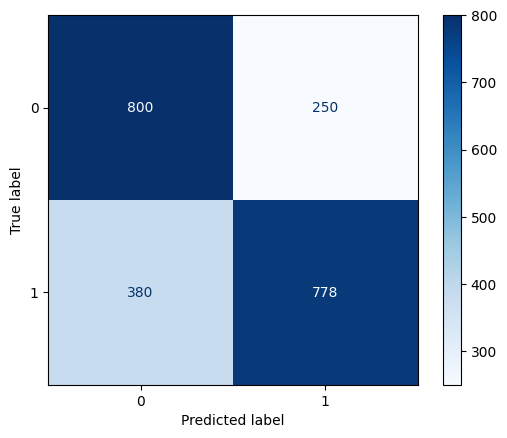

In [12]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, predictions))
disp=ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap=plt.cm.Blues)


El modelo clasifica correctamente un alto número de mensajes  no sexistas (800 de un total de 1050). Sin embargo, de los 1158 mensajes  sexistas, el modelo únicamente es capaz de clasificar correctamente la mitad (778). El resto (380) lo está clasificando como no sexistas.
Por tanto, el modelo está generando muchos falsos negativos (muchos mensajes sexistas no son identificados).